'''
The following project is a scraper program that scrapes the posted contents of any specific journalist of the 
New York Times.  The program uses the scraped data to generate a profile using NLP to shed light into the sentiment 
of the journalist, essentially a "profiler" or a journalist background checker(emotionally).

'''

In [1]:
from bokeh.plotting import figure, output_file, show
from textblob import TextBlob
import json
import csv
import re
import codecs
import httplib
import unidecode
import cookielib
import htmlentitydefs
from cookielib import CookieJar
from bs4 import BeautifulSoup
import urllib
import requests
import urllib2
import numpy as np
from goose import Goose
from nytimesarticle import articleAPI
from textblob import TextBlob
from textblob import Word
import nltk
from nltk.book import *
from nltk.collocations import *
from nltk.tokenize import *
import re
import pandas as pd

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [2]:
# API keys for accessing the New York Times API
my_key = "ff6b310d93d29fcc1bb1325579df516a:14:73310489"
api = articleAPI(my_key)
test = "http://www.nytimes.com/2015/10/21/us/politics/no-classified-leak-revealed-in-cia-directors-email.html"
test1 = "http://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file-in-python"
page = urllib2.urlopen("http://www.nytimes.com").read()


In [3]:
##############################################
# Parser Function
##############################################

def url_parser(full_name):
   '''
   url_parser takes in a name and formats it into a valid New York times 
   url that accesses the posts/publications of the journalist specified by
   the input full_name

   '''
   # may need to implement non alpha-filter for symbol characters
   full_name = full_name.lower()
   tmp_split = full_name.split()
   alpha_tag = ""

   if (len(tmp_split) == 3):
   	alpha_tag = tmp_split[2]
   else:
   	alpha_tag = tmp_split[1]

   	# url structure for NYT pages
   nyt_url = "http://topics.nytimes.com/top/reference/timestopics/people/"

   index = "index.html"
   alpha_tag = alpha_tag[0]
   name_string = full_name.replace (" ", "_").replace(".","")
   nyt_url = nyt_url+alpha_tag +"/"+name_string + "/" +index
 
   return nyt_url

In [4]:
def postHistory(url):
   page = urllib2.urlopen(url).read()
   soup = BeautifulSoup(page)
   html = soup.prettify()

   history = []

   for anchor in soup.findAll('p',attrs = {"class": "story-body-text story-content"}):
      history.append(anchor)

   return history

In [5]:
################################
# Test Cases 
################################

def myTest(function, expected):
    '''
    myTest is a function that serves as a means to test the 
    url parser by using test cases.


    '''
    return eval(function) == expected




In [6]:
def request_url(url, txdata, txheaders):
    """Gets a webpage's HTML."""
    req = Request(url, txdata, txheaders)
    handle = urlopen(req)
    html = handle.read()
    return html

In [7]:
urlopen = urllib2.urlopen
Request = urllib2.Request

# Install cookie jar in opener for fetching URL
cookiejar = cookielib.LWPCookieJar()
opener = urllib2.build_opener(urllib2.HTTPCookieProcessor(cookiejar))
urllib2.install_opener(opener)

URL_REQUEST_DELAY = 1
BASE = 'http://www.nytimes.com'
TXDATA = None
TXHEADERS = {'User-agent': 'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)'}
OUTPUT_FILE = 'nyt_top_stories.txt'

html = request_url("http://www.nytimes.com/2015/10/26/world/europe/russian-presence-near-undersea-cables-concerns-us.html?ref=topics", TXDATA, TXHEADERS)
# Use BeautifulSoup to easily navigate HTML tree


In [8]:
def extractArticle(url):
  g = Goose()
  article = g.extract(url=url)
  return article.cleaned_text


def extractArticleList(datum):
  archive = []
  for ii in datum:
    archive.append(extractArticle(ii))
  return archive


def extractDate(lst):
  dates = []
  for ii in lst:
        match = re.search(r'\d{4}-\d{2}-\d{2}',str(ii))
        dates.append(str(match.group(0)))
  return dates

def extractWrapper(name, number):
  x=CollectPostHistory(name,number)
  tmp = extractArticleList(x[0])
  dates = extractDate(x[1])
  raw = " ".join(tmp)
  content = raw.encode('ascii', 'ignore')
  return dates, tmp, content


In [9]:
################################ 
# New York Times API Shtufff
#################################

def getPostHistory(author,number):
    articles = api.search(q = author, fl = ["web_url","pub_date"],page = number,
        begin_date = 20111231,fq = {'source':['The New York Times']})
    x=json.dumps(articles, sort_keys=True,indent=4, separators=(',', ': '))
    parsed_json = json.loads(x)
    y = parsed_json["response"]
    parsed_docs = y["docs"]
    tmp = []
    date = []
    #print parsed_docs
    for ii in parsed_docs:
        tmp.append(ii['web_url']) 
        date.append(ii["pub_date"])
    return tmp, date


def CollectPostHistory(author,amount):
    index = int(amount/10)
    start = []
    dates = []
    for ii in range(index):
        tmp, date = getPostHistory(author,ii)
        start.extend(tmp)
        dates.extend(date)
    return start, dates


def getDate(lst):
    tmp = []
    for ii in lst:
        my_range = [int(s) for s in ii.split() if s.isdigit()]
        tmp.extend(my_range)

    return tmp

In [10]:
#######################
#Frequency Wrapper Function
#######################

#"VB", "VBN", "VBP", "VBZ"
# "RB", "RBR", "RBS"

# Note: filter out mr. mrs. 
def castFreqDF(cleantext):
  '''
  castFreqDF is a function that tokenizes and tags parts-of-speech to clean text,
  filters by tags so as to exclude conjunctives, prepositions, determiners, etc., 
  and then casts the filtered text into a data frame that has been sorted by word frequency

  Arguments:
  cleantext -- clean text data processed by nltk functions and tools

  Output:
  df -- dataframe containing word frequency supplied by tag-filtered cleantext

  '''
  tokenized = word_tokenize(cleantext)
  tags = nltk.pos_tag(tokenized)

  def filteredtags(tags):
    wantedTags = ["FW", "JJ", "JJR", "JJS", "NN", "NNP", "NNPS", "NNS"]
    ftags = []
    tagtag = []
    for t in tags:
      if t[1] in wantedTags:
        ftags.append(t[0])
        tagtag.append(t[1])
      
    return ftags , tagtag

  x = filteredtags(tags)
  
  fdist = FreqDist(x[0])
  taglist = x[1]
  vocab1 = fdist.keys()

  tmp1 = []
  tmp2 = []
  #tmp3 = []

  for ii in fdist:
    tmp1.append(ii)
  for jj in fdist:
    tmp2.append(fdist[jj])

  # for jj in tmp1:
  #   tokenized = word_tokenize(jj)
  #   tmp3.append(nltk.pos_tag(tokenized))

  s1 = pd.Series(tmp1)
  s2 = pd.Series(tmp2)
  #s3 = pd.Series(tmp3)

  d = {"Word":s1,
    "Count" : s2}

  df = pd.DataFrame(d)
  return df.sort(["Count"], ascending = False, axis = 0)

In [11]:
################################
# Sentiment Function 
################################

def sentimentpolarity(sentiment_list):
  '''
  sentimentpolarity is a function that intakes a list of text strings, analyzes
  each text's polarity and subjectivity using the TextBlob package, and casts
  the text and these two parameters into a dataframe

  Arguments:
  sentiment_list -- A list containing strings of an author's texts
  
  Output:
  df -- Dataframe containing polarity and subjectivity for each text
  '''
  tri_list = sentiment_list

  dates = tri_list[0]
  articles = tri_list[1]

  sample = []
  polarity = []
  subjectivity = []
  tmp_dates = []

  for ii in articles:
    sample.append(ii)
  for jj in articles:
    blob = TextBlob(jj)
    polarity.append(blob.sentiment.polarity)
  for kk in articles:
    blob2 = TextBlob(kk)
    subjectivity.append(blob2.sentiment.subjectivity)

  for kk in range(len(articles)):
    tmp_dates.append(dates[kk])

  c1 = pd.Series(sample)
  c2 = pd.Series(polarity)
  c3 = pd.Series(subjectivity)
  c4 = pd.Series(tmp_dates)

  d = {"Sample":c1,
    "Polarity":c2,
    "Subjectivity":c3,
    "Date":c4}
  df = pd.DataFrame(d)

  return df.sort('Date')

In [12]:
# sns.tsplot(data=df_subjectivity, value = 'Subjectivity')
# # fig, ax = plt.subplots()
# sns.tsplot(data=df_polarity, value = 'Subjectivity')
# # sns.tsplot(data = df_subjectivity, time='Date', value='Value', unit='Unit', ax=ax)

In [13]:
# fig, ax = plt.subplots()
# sns.tsplot(data=df_polarity, value = 'Subjectivity')

In [14]:
author = "David Brooks"
x = extractWrapper(author, 20)

In [15]:
content = x[2]
cleantext = content.lower()
cleantext = re.sub('[.:\',\-!;"()?]',"",cleantext).strip()
#y = castFreqDF(cleantext)
data1 = sentimentpolarity(x)
def overallSentiment(input_text):
  blob = TextBlob(input_text)
  return blob.sentiment
overall = overallSentiment(cleantext)


In [16]:
# Word Frequency 
y = castFreqDF(cleantext)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import datetime
import matplotlib.cbook as cbook
%matplotlib inline
import matplotlib.dates as dates

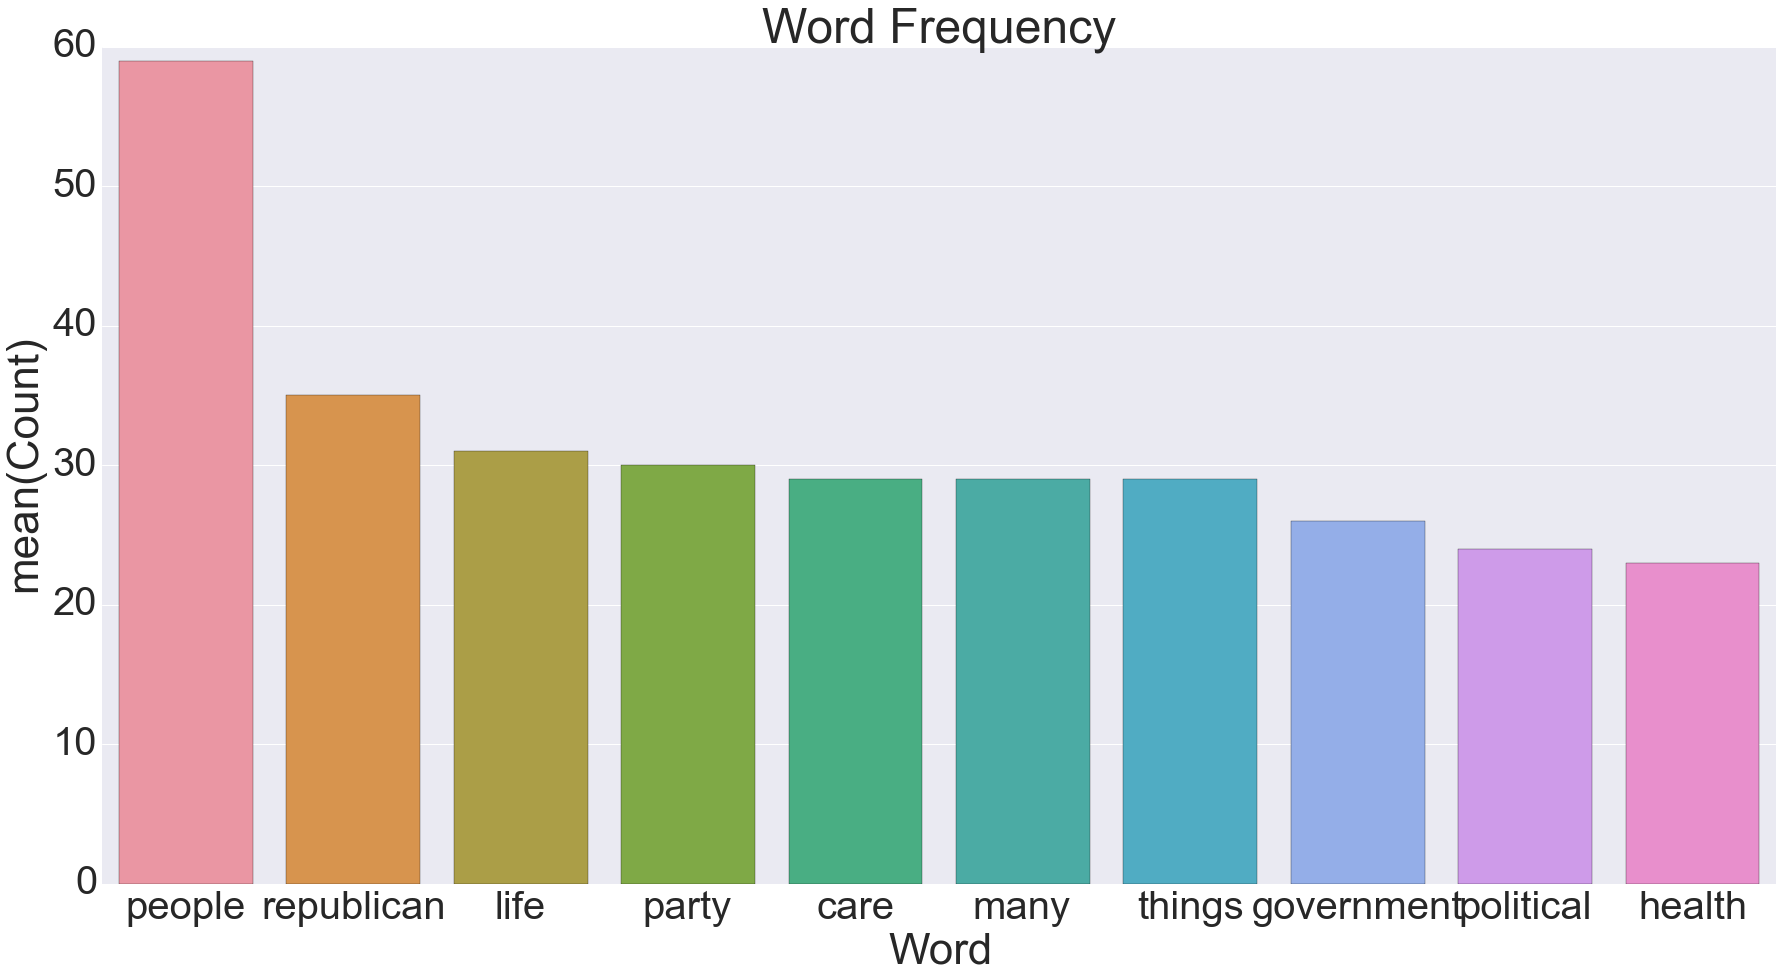

In [28]:
top10 = y[:10]
top10
plt.figure(figsize=(30, 15))
sns.set(font_scale=4)
sns.barplot(x="Word", y="Count", data=top10)
plt.title("Word Frequency")

In [20]:
df_overall = data1.set_index("Date")
df_polarity = df_overall["Polarity"]
df_subjectivity = df_overall["Subjectivity"]
df_overall

,Polarity,Sample,Subjectivity
Date,,,
2015-08-03,0.156518,"David Brooks (“The Structure of Gratitude,” co...",0.474988
2015-08-04,0.115193,"“Two Cheers for Capitalism,” by David Brooks (...",0.443141
2015-09-18,0.083321,My PBS colleague Mark Shields recently reminde...,0.473005
2015-09-22,0.217917,One of Pope Francis’ favorite novels is “The B...,0.548072
2015-09-25,0.063095,"America was settled, founded and built by peop...",0.405109
2015-09-29,0.081593,Pretty much everybody from Barack Obama to Car...,0.474995
2015-10-02,0.124881,Carly Fiorina’s presidential campaign has been...,0.473142
2015-10-06,0.133427,Many American universities were founded as rel...,0.359332
2015-10-06,0.091829,While Carly Fiorina’s positions on abortion ri...,0.395248


In [36]:
# CONVERT DAT CODE INTO 'STRING' BAE 
content = data1["Sample"]
text = " ".join(content)
text = text.encode("ascii","ignore")

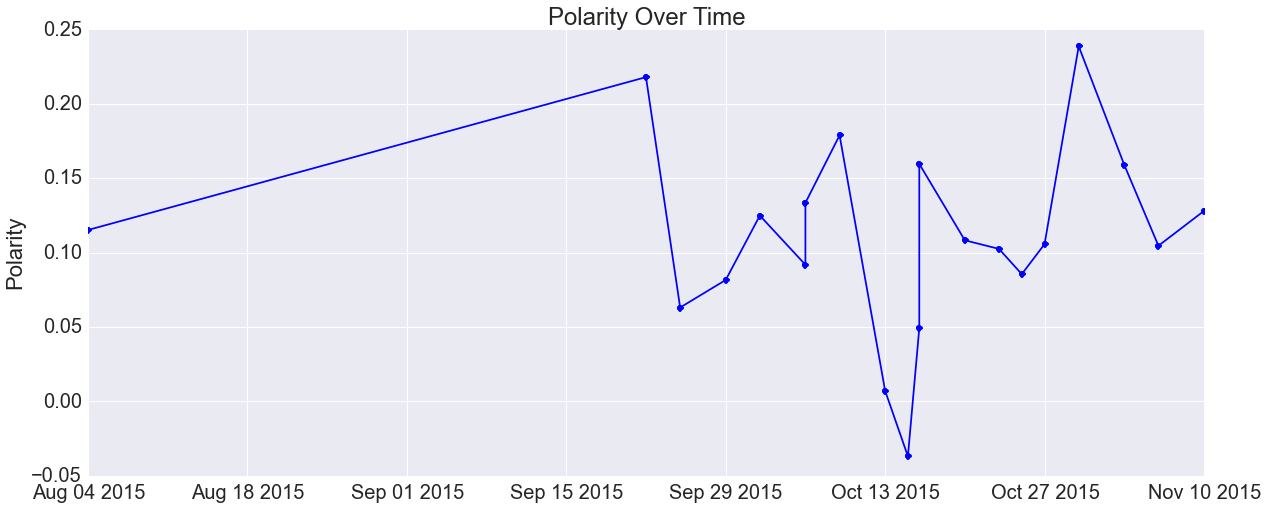

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import datetime
import matplotlib.cbook as cbook
%matplotlib inline
import matplotlib.dates as dates
y = data1["Date"]
x = data1["Polarity"]
x2 = data1["Subjectivity"]
new_x = dates.datestr2num(y[0])
new_x
blank = []
date_float = []

for ii in data1["Date"]:
    date_float.append(dates.datestr2num(ii))
    
for ii in date_float:
    blank.append(dates.num2date(ii))
    
plt.figure(figsize=(20, 8))
sns.set(font_scale = 2)
plt.plot_date(blank, x, fmt="bo", tz=None, xdate=True,linestyle='-')
plt.ylabel('Polarity')
plt.title('Polarity Over Time')

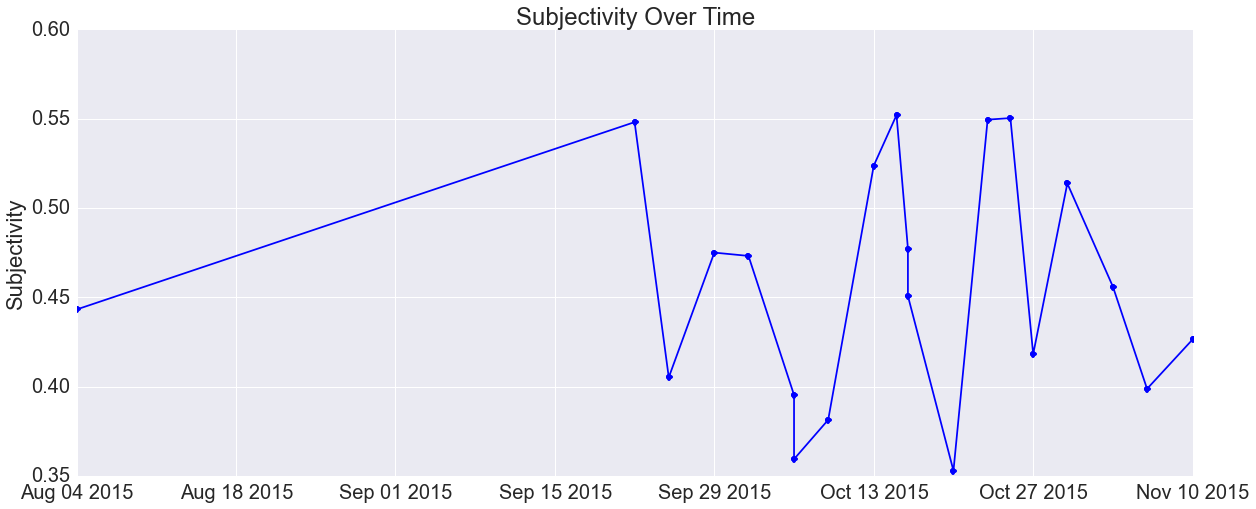

In [38]:
plt.figure(figsize=(20, 8))
plt.plot_date(blank, x2, fmt="bo", tz=None, xdate=True,linestyle='-',)
plt.ylabel('Subjectivity')
plt.title('Subjectivity Over Time')

In [39]:
# Call To Blue Mix YAYYYYY
url = "https://gateway.watsonplatform.net/personality-insights/api"
username = "88890f90-46c8-4029-90ae-4af2677fdb1b"
password = "cXaWijcdVDYv"

response = requests.post(url + "/v2/profile",
                          auth=(username, password),
                          headers = {"content-type": "text/plain"},
                          data=text)
    

In [40]:
x = json.loads(response.text)
y = x["tree"]["children"]
trait = []
percentage = []
for ii in y:
    for jj in ii["children"]:
        for kk in jj["children"]:
            #print kk["name"]
            trait.append(kk["name"])
            #print kk["percentage"]
            percentage.append(kk["percentage"])
            if "children" in kk:
                for zz in kk["children"]:
                    #print zz["id"]
                    trait.append(zz["id"])
                    #print zz["percentage"]
                    percentage.append(zz["percentage"])
            else:
                print " "

In [41]:
from bokeh.plotting import figure, show, output_file, vplot

df = {"Percentage": pd.Series(percentage),
      "Trait":pd.Series(trait)}

df = pd.DataFrame(df)
df = df.reindex_axis(['Trait', 'Percentage'], axis=1)

openess = [trait[0:7]],[percentage[0:7]]
consc = [trait[7:14]],[percentage[7:14]]
extra = [trait[14:21]],[percentage[14:21]]
agree = [trait[21:28]],[percentage[21:28]]
emo = [trait[28:35]],[percentage[28:35]]
needs = [trait[35:47]],[percentage[35:47]]
values = [trait[47:52]],[percentage[47:52]]
# Bokeh Personality Graphs
factors = openess[0][0]
x0 = [0] * len(openess[0][0])
x =  openess[1][0]
output_file("categorical.html", title="categorical.py example")
p1 = figure(title="Big Five: Openess", tools="resize,save", y_range=factors, x_range=[0,1])
p1.segment(x0, factors, x, factors, line_width=5, line_color="blue", )
p1.circle(x, factors, size=6, fill_color="blue", line_color="blue", line_width=3, )

factors = consc[0][0]
x0 = [0] * len(consc[0][0])
x =  consc[1][0]
output_file("categorical.html", title="categorical.py example")
p2 = figure(title="Big Five: Conscientiousness", tools="resize,save", y_range=factors, x_range=[0,1])
p2.segment(x0, factors, x, factors, line_width=5, line_color="green", )
p2.circle(x, factors, size=6, fill_color="green", line_color="green", line_width=3, )

factors = extra[0][0]
x0 = [0] * len(extra[0][0])
x =  extra[1][0]
output_file("categorical.html", title="categorical.py example")
p3 = figure(title="Big Five: Extraversion", tools="resize,save", y_range=factors, x_range=[0,1])
p3.segment(x0, factors, x, factors, line_width=5, line_color="red", )
p3.circle(x, factors, size=6, fill_color="red", line_color="red", line_width=3, )

factors = agree[0][0]
x0 = [0] * len(agree[0][0])
x =  extra[1][0]
output_file("categorical.html", title="categorical.py example")
p4 = figure(title="Big Five: Agreeableness", tools="resize,save", y_range=factors, x_range=[0,1])
p4.segment(x0, factors, x, factors, line_width=5, line_color="purple", )
p4.circle(x, factors, size=6, fill_color="purple", line_color="purple", line_width=3, )

factors = emo[0][0]
x0 = [0] * len(emo[0][0])
x =  emo[1][0]
output_file("categorical.html", title="categorical.py example")
p5 = figure(title="Big Five: Emotional", tools="resize,save", y_range=factors, x_range=[0,1])
p5.segment(x0, factors, x, factors, line_width=5, line_color="orange", )
p5.circle(x, factors, size=6, fill_color="orange", line_color="orange", line_width=3, )

factors = values[0][0]
x0 = [0] * len(values[0][0])
x =  values[1][0]
output_file("categorical.html", title="categorical.py example")
p7 = figure(title="Values", tools="resize,save", y_range=factors, x_range=[0,1])
p7.segment(x0, factors, x, factors, line_width=5, line_color="gray", )
p7.circle(x, factors, size=6, fill_color="gray", line_color="gray", line_width=3, )

factors = needs[0][0]
x0 = [0] * len(needs[0][0])
x =  needs[1][0]
output_file("categorical.html", title="categorical.py example")
p6 = figure(title="Needs", tools="resize,save", y_range=factors, x_range=[0,1])
p6.segment(x0, factors, x, factors, line_width=5, line_color="pink", )
p6.circle(x, factors, size=6, fill_color="pink", line_color="pink", line_width=3, )

show(vplot(p1,p2,p3,p4,p5,p6,p7))  # open a browser